In [1]:
%matplotlib inline
from __future__ import division
import datetime
import numpy as np
import time
import matplotlib.pyplot as plt
import random
import time
import scipy
from scipy import optimize, signal
import pandas as pd
from collections import Counter, defaultdict
from itertools import count
from tqdm import *
import copy
from defenitions import *

large_number = 9999999999999999.9 # float('inf')*0 = nan! so use large number


100%|███████████████████████████████| 291552/291552 [00:26<00:00, 11035.69it/s]


In [2]:
def cost_d(x,s,definitions):
    """Return a float or integer"""
    # Pump power consumption - Power output of the turbine per time step and error state 
    power_con = definitions['pump_dict'][x][(s)][1]-definitions['Power_table_det'][s[0]]
    if power_con >= 0:
        return power_con*definitions['Tariff'][s[0]]*int(definitions['Time_step'][:-1])/60
    else:
        return power_con*int(definitions['Time_step'][:-1])*5.5/60 # Export price
    

def new_state_d(x,s,definitions):
    """Return a tuple of the state"""
    
    
    return (s[0]+1, definitions['pump_dict'][x][(s)][0])
    

def val_T(s,settings):
    """Return a float or int"""
    if s[1] < settings['Initial state'][1]:
        return large_number
    else:
        return 0

In [3]:
def cost(x,s,definitions):
    """Return a float or integer"""
  
     
    # Pump power consumption - Power output of the turbine per time step and error state 
    power_con = definitions['pump_dict'][x][(s[:-1])][1]-definitions['Power_table'][s[0]][s[2]]
    
    if power_con >= 0:
        return power_con*definitions['Tariff'][s[0]]*int(definitions['Time_step'][:-1])/60
    else:
        return power_con*int(definitions['Time_step'][:-1])*5.5/60 # Export price
    

def new_state(x,s,definitions):
    """Return a tuple o fthe state"""

    return (s[0]+1, definitions['pump_dict'][x][(s[:-1])][0], s[2])
    

def val_T(s,settings):
    """Return a float or int"""
    if s[1] < settings['Initial state'][1]:
        return large_number
    else:
        return 0
    
def val_T2(s,settings):
    """Return a float or int"""
    return s[1]*314*8


In [4]:
def cost_from_schedule(Initial_fill,schedule,pump_obj,pipe_obj,tank_obj,turbine_power,base_demand,water_demand,Time_step,Tariff):
    """
    Computes the actual energy consumption and operating cost of a schedule
    
    Returns
    -------
    cost
    """
    Cost = 0
    state = Initial_fill
    for t, P_t in enumerate(turbine_power):
        q, P_p = flowrate_gen_real(schedule[t],pump_obj,pipe_obj,tank_obj,state)
        
        state = state+(q - base_demand*water_demand[t] )/tank_obj.Area
        
        Power_balance = P_p - P_t
        Cost += cost_from_power(Tariff[t],Power_balance,Time_step) 
        
    return Cost , state# in p

In [ ]:
for next_day in trange(365): 
    for J in [5,11,21,31]:
        for Time_step in ['15T','30T','60T']:  
            turb = Enercon # Vestas # Enercon # EWT
            #Time_step = '120T'
            day = 365
            day += next_day
            Filter = 0.03
            base_demand = 150.0

            tank = Tank(15,0,5,Dia=20)
            # print 'Tank capacity in hours:', tank.capacity_h(base_demand)
            Number_of_states = 400
            initial_fill_level = np.linspace(tank.Hmin,tank.Hmax,Number_of_states)[0]#[int(Number_of_states/2)]

            pipe1 = pipe(15000,0.53) #selected pipe!

            #plot_T_mat(T_mat,save=False,name='T_mat_J='+str(J)+'Time_step='+Time_step)
            decisions = ['x=0','x=1','x=2','x=3','x=4','x=5']           
            pump = Hyd_pump(pump_data,['x=1','x=2','x=3','x=4','x=5'])

            df_o['Forecasted wind'] = make_Forecast(df_o['Avg Wind Speed @ 140ft [m/s]'],order=2,digital_pass=Filter)

            No_of_time_steps = int(24*60/float(Time_step[:-1]))
            df = df_o.resample(Time_step)#.mean()
            df = df.dropna()

            df['Forecast error'] = df['Avg Wind Speed @ 140ft [m/s]']-df['Forecasted wind'] 
            df['Forecast error state'], states = digitize_wind(df['Forecast error'],J)

            for j in range(J):
                df['Forecasted wind at J='+str(j)] = df['Forecasted wind']+states[j]-states[df['Forecast error state']] 
                df['Power at J='+str(j)] = df['Forecasted wind at J='+str(j)].map(lambda x: turb.turb_power(x))

            df['Forecasted Power'] = df['Forecasted wind'].map(lambda x: turb.turb_power(x))
            df['True Power'] = df['Avg Wind Speed @ 140ft [m/s]'].map(lambda x: turb.turb_power(x))
            T_mat, indices = tmatrix(df['Forecast error state'],J_max=J)

            Tariff = tariff.resample(Time_step ).ffill().tolist()[:-1]
            Tariff_o = tariff.resample(Time_step ).ffill().tolist()[:-1]

            #water_demand
            idx = pd.date_range('1/1/2011', periods=49, freq='30T')
            water_demand = pd.Series([0.45283019, 0.45283019, 0.50943396, 0.50943396, 0.45283019, 0.45283019,
                                      0.50943396, 0.50943396, 0.67924528, 0.67924528,  1.24528302,  1.24528302,
                                      1.35849057, 1.35849057, 1.13207547, 1.13207547,  0.90566038,  0.90566038,
                                      0.79245283, 0.79245283, 0.8490566,  0.8490566 ,  0.90566038,  0.90566038,
                                      0.90566038, 0.90566038, 1.0754717,  1.0754717 ,  1.24528302,  1.24528302,
                                      1.35849057, 1.35849057, 1.81132075, 1.81132075,  2.03773585,  2.03773585,
                                      1.69811321, 1.69811321, 1.47169811, 1.47169811,  0.90566038,  0.90566038,
                                      0.56603774, 0.56603774, 0.56603774, 0.56603774,  0.56603774,  0.56603774, 0.45283019],
                                     index=idx)
            water_demand = water_demand.resample(Time_step).ffill().tolist()
            water_demand = water_demand[0:No_of_time_steps]
            water_demand = np.array(water_demand) / np.array(water_demand).mean()


            results =pd.read_pickle('temp_results')
            # Stoch defenitions
            pumping_stoch = StochasticProgram()
            pumping_stoch.add_transition_matrix(T_mat)
            pumping_stoch.set_step_number(No_of_time_steps)
            pumping_stoch.add_decisions_set(set(decisions))
            pumping_stoch.add_cost_function(cost)
            pumping_stoch.add_state_eq(new_state)
            pumping_stoch.add_final_value_expression(val_T2)
            pumping_stoch.add_state_limits(lower=[tank.Hmin,0],upper = [tank.Hmax,J])



            pumping_stoch.add_definition('Time_step',Time_step)


            # Deterministic
            pumping = DynamicProgram()
            pumping.set_step_number(No_of_time_steps)
            pumping.add_decisions_set(set(decisions))
            pumping.add_cost_function(cost_d)
            pumping.add_state_eq(new_state_d)
            pumping.add_final_value_expression(val_T2)
            pumping.add_state_limits(lower=tank.Hmin,upper = tank.Hmax)
            pumping.set_inital_state( (0,initial_fill_level) )

            pumping.add_definition('Time_step',Time_step)

            pumping_ideal = copy.deepcopy(pumping)


            ## run through the day
            dec = []
            dec_ideal = []
            dec_forecast = []
            cost_stoch = [] # acutal cost of operation
            cost_stoch_calc = [] # estimated cost of ops
            cost_forecast = [] # acutal cost of operation
            cost_forecast_calc = [] # estimated cost of ops
            cost_ideal = [] # acutal cost of operation
            cost_ideal_calc = [] # estimated cost of ops

            state_sim_stoch = np.zeros(No_of_time_steps+1)
            state_sim_stoch[0] = initial_fill_level
            state_sim_ideal = np.zeros(No_of_time_steps+1)
            state_sim_ideal[0] = initial_fill_level
            state_sim_forecast = np.zeros(No_of_time_steps+1)
            state_sim_forecast[0] = initial_fill_level

            fill_level_stoch = initial_fill_level
            fill_level_ideal = initial_fill_level
            fill_level_forecast = initial_fill_level
            fill_level_stoch_record = []
            fill_level_ideal_record = []
            fill_level_forecast_record = []

            P_stoch = np.zeros(No_of_time_steps)
            P_ideal = np.zeros(No_of_time_steps)
            P_forecast = np.zeros(No_of_time_steps)

            init = int(No_of_time_steps*day)

            for t in range(No_of_time_steps):
                init += t

                fill_level_stoch_record.append(fill_level_stoch)
                fill_level_ideal_record.append(fill_level_ideal)
                fill_level_forecast_record.append(fill_level_forecast)

                # Define wind states
                df_slice = df.ix[init:init+No_of_time_steps,:]
                Power_table = df_slice.ix[:,5:int(J*2)+5:2] 
                Power_table = Power_table.as_matrix() # Array of the set of power from the wind turbine
                Power_table_det = df_slice['Forecasted Power']
                Power_table_true = df_slice['True Power']
                Power_table[0][:] =  df_slice['True Power'][0]

                # cheat to verfy
                #Power_table = np.array([df_slice['True Power'].as_matrix().tolist()]*J).T


                wind_error = int(df_slice['Forecast error state'][0]) # Inital J value


                #update for new solution
                pump_dict = make_pump_dict(tank,pump,pipe1,decisions,water_demand,base_demand,Number_of_states)


                pumping.add_definition('Tariff',Tariff)    
                pumping.add_definition('Power_table_det',Power_table_det)
                pumping.add_definition('pump_dict',pump_dict)  
                pumping.settings['Initial state'] = (0,fill_level_forecast)   


                pumping_ideal.add_definition('Tariff',Tariff)
                pumping_ideal.add_definition('Power_table_det',Power_table_true)
                pumping_ideal.add_definition('pump_dict',pump_dict)
                pumping_ideal.settings['Initial state'] = (0,fill_level_ideal)

                pumping_stoch.add_definition('Tariff',Tariff)   
                pumping_stoch.add_definition('Power_table',Power_table)
                pumping_stoch.add_definition('pump_dict',pump_dict)
                pumping_stoch.settings['Initial state'] = (0,fill_level_stoch,wind_error)

                cost_stoch_calc.append(pumping_stoch.solve()) # Solve to DP
                cost_ideal_calc.append(pumping_ideal.solve())
                cost_forecast_calc.append(pumping.solve())

                # Record the solutions and actual analysis
                # Stoch
                d_stoch = pumping_stoch.results['schedule'][wind_error][0]

                q_stoch, P_stoch[t] = flowrate_gen_real(d_stoch,pump,pipe1,tank,state_sim_stoch[t])
                state_sim_stoch[t+1] = state_sim_stoch[t]+(q_stoch - base_demand*water_demand[t] )/tank.Area
                cost_stoch.append(cost_from_power(Tariff[t],P_stoch[t],Time_step))

                dec.append(d_stoch)

                # ideal
                d_ideal = pumping_ideal.results['schedule'][0]
                q_ideal, P_ideal[t] = flowrate_gen_real(d_ideal,pump,pipe1,tank,state_sim_ideal[t])
                cost_ideal.append(cost_from_power(Tariff[t],P_ideal[t],Time_step))
                state_sim_ideal[t+1] = state_sim_ideal[t]+(q_ideal - base_demand*water_demand[t] )/tank.Area
                dec_ideal.append(d_ideal)

                # forecast
                d_forecast = pumping.results['schedule'][0]
                q_forecast, P_forecast[t] = flowrate_gen_real(d_forecast,pump,pipe1,tank,state_sim_forecast[t])
                cost_forecast.append(cost_from_power(Tariff[t],P_forecast[t],Time_step))
                state_sim_forecast[t+1] = state_sim_forecast[t]+(q_forecast - base_demand*water_demand[t] )/tank.Area
                dec_forecast.append(d_forecast)



                #update after call:
                fill_level_stoch = pump_dict[d_stoch][(0,fill_level_stoch)][0]
                fill_level_ideal = pump_dict[d_ideal][(0,fill_level_ideal)][0]
                fill_level_forecast = pump_dict[d_forecast][(0,fill_level_forecast)][0]

                # update water demand
                water_demand = np.roll(water_demand,-1)
                Tariff = np.roll(Tariff,-1)


            fill_level_stoch_record.append(fill_level_stoch)
            fill_level_ideal_record.append(fill_level_ideal)
            fill_level_forecast_record.append(fill_level_forecast)


            cost_ideal_sim, final_state_ideal = cost_from_schedule(initial_fill_level,
                                                dec_ideal,
                                                pump,pipe1,tank,df_slice['True Power'], base_demand,water_demand,Time_step,Tariff_o) 

            cost_det_sim, final_state_det = cost_from_schedule(initial_fill_level,
                                                dec_forecast,
                                                pump,pipe1,tank,df_slice['True Power'],base_demand,water_demand,Time_step,Tariff_o)

            cost_stoch_sim, final_state_stoch = cost_from_schedule(initial_fill_level,
                                                dec,
                                                pump,pipe1,tank,df_slice['True Power'],base_demand,water_demand,Time_step,Tariff_o)




            rslts = [day, J, Time_step, turb.name, base_demand, 1.1 , 
                       dec,dec_ideal, dec_forecast,
                       cost_stoch_sim,cost_ideal_sim,cost_det_sim,
                       initial_fill_level,final_state_stoch, final_state_ideal, final_state_det ]   



            results.loc[len(results)] = rslts
            results.to_pickle('temp_results')

  0%|                                                  | 0/365 [00:00<?, ?it/s]C:\Users\rmm08\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:26: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)


5
5
5
9
10
10
15
19
19
22


In [34]:
results
 

Day    J Time step Turbine  Base demand  Version  \
0  526.0  3.0      120T     E53        150.0      1.0   
1  526.0  3.0      120T     E53        150.0      1.0   

                                      Schedule stoch  \
0  [x=1, x=1, x=0, x=0, x=1, x=1, x=1, x=0, x=1, ...   
1  [x=1, x=1, x=0, x=0, x=1, x=1, x=1, x=0, x=1, ...   

                                       Schedule real  \
0  [x=1, x=2, x=0, x=0, x=1, x=1, x=1, x=0, x=1, ...   
1  [x=1, x=2, x=0, x=0, x=1, x=1, x=1, x=0, x=1, ...   

                                   Schedule forecast    Cost stoch  \
0  [x=1, x=1, x=0, x=0, x=1, x=1, x=1, x=0, x=1, ...  1.701944e+06   
1  [x=1, x=1, x=0, x=0, x=1, x=1, x=1, x=0, x=1, ...  1.701944e+06   

      cost real      cost det  Initial level  Final level stoch  \
0  1.755028e+06  1.701944e+06            0.0           2.006276   
1  1.755028e+06  1.701944e+06            0.0           2.006276   

   Final level real  Final level det  
0          2.129765         2.006276  
1          2.129765         2.006276

In [ ]:
#pumping_ideal.plot_results(name='day'+str(day)+'_T='+str(No_of_time_steps)+'_J='+str(J),save=False)

In [ ]:
pumping_stoch.plot_results(name='day'+str(day)+'_T='+str(No_of_time_steps)+'_J='+str(J),save=False)


In [728]:
stoch_sched = [int(i[2]) for i in dec]
det_sched = [ int(i[2]) for i in  dec_forecast] #pumping.results['schedule'].values()]
ideal_sched = [ int(i[2]) for i in dec_ideal]#pumping_ideal.results['schedule'].values()]

#plt.pcolor([stoch_sched], vmin = 0, vmax = 5)
# plt.pcolormesh([stoch_sched]*5, vmin = 0, vmax = 5)
# cbar = plt.colorbar(ticks=range(6))
# cbar.set_ticklabels(decisions)
# plt.plot(range(25),fill_level_stoch_record,'b')
# plt.ylabel('Tank Level')
# plt.axis([0, No_of_time_steps, 0, tank.Hmax])
# plt.show()

# plt.pcolor([det_sched], vmin = 0, vmax = 5)
# #plt.pcolor([dec_forecast], vmin = 0, vmax = 5)
# cbar = plt.colorbar(ticks=range(6))
# cbar.set_ticklabels(decisions)
# plt.ylabel('Deterministic schedule')
# plt.show()

# plt.pcolor([ideal_sched], vmin = 0, vmax = 5)
# #plt.pcolor([dec_ideal], vmin = 0, vmax = 5)
# cbar = plt.colorbar(ticks=range(6))
# cbar.set_ticklabels(decisions)
# plt.ylabel('Ideal schedule')
# plt.show()

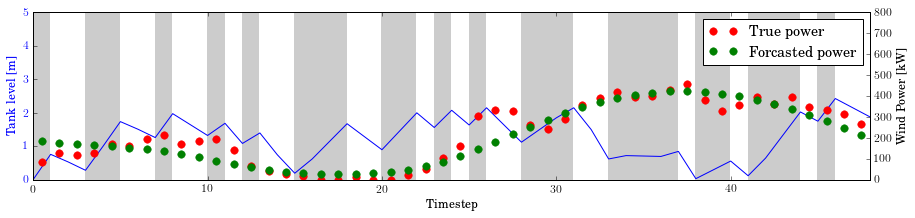

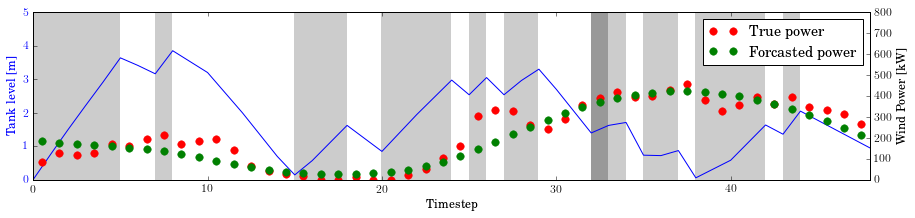

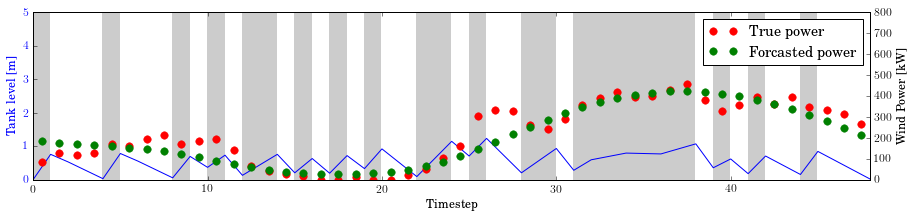

In [736]:
actual_power = df.ix[int(No_of_time_steps*day):int(No_of_time_steps*day)+No_of_time_steps,:]['True Power']
forecasted_power = df.ix[int(No_of_time_steps*day):int(No_of_time_steps*day)+No_of_time_steps,:]['Forecasted Power']


fig, ax1 = plt.subplots(figsize=(15,3))
ax1.pcolormesh([stoch_sched]*tank.Hmax, vmin = 0, vmax = 5)
ax1.plot(range(len(stoch_sched)+1),fill_level_stoch_record,'b')
ax1.set_xlabel('Timestep')
ax1.axis([0, No_of_time_steps, 0, tank.Hmax])
ax1.set_ylabel('Tank level [m]', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')

ax2 = ax1.twinx()
ax2.plot(np.array(range(No_of_time_steps))+0.5, actual_power,'r.',Markersize=15,label='True power')
ax2.plot(np.array(range(No_of_time_steps))+0.5, forecasted_power,'g.',Markersize=15,label='Forcasted power')
ax2.legend()
ax2.axis([0, No_of_time_steps, 0, turb.Power_rating])
ax2.set_ylabel('Wind Power [kW]', color='k')
for tl in ax2.get_yticklabels():
    tl.set_color('k')
plt.savefig('stoch_schedule.pdf',format='pdf')
plt.show()




fig, ax1 = plt.subplots(figsize=(15,3))
ax1.pcolormesh([det_sched]*tank.Hmax, vmin = 0, vmax = 5)
ax1.plot(range(No_of_time_steps+1),fill_level_forecast_record,'b')
ax1.set_xlabel('Timestep')
ax1.axis([0, No_of_time_steps, 0, tank.Hmax])
ax1.set_ylabel('Tank level [m]', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')

ax2 = ax1.twinx()
ax2.plot(np.array(range(No_of_time_steps))+0.5, actual_power,'r.',Markersize=15,label='True power')
ax2.plot(np.array(range(No_of_time_steps))+0.5, forecasted_power,'g.',Markersize=15,label='Forcasted power')
ax2.legend()
ax2.axis([0, No_of_time_steps, 0, turb.Power_rating])
ax2.set_ylabel('Wind Power [kW]', color='k')
for tl in ax2.get_yticklabels():
    tl.set_color('k')
plt.savefig('Det_schedule.pdf',format='pdf')
plt.show()





fig, ax1 = plt.subplots(figsize=(15,3))
ax1.pcolormesh([ideal_sched]*tank.Hmax, vmin = 0, vmax = 5)
ax1.plot(range(No_of_time_steps+1),fill_level_ideal_record,'b')
ax1.set_xlabel('Timestep')
ax1.axis([0, No_of_time_steps, 0, tank.Hmax])
ax1.set_ylabel('Tank level [m]', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')

ax2 = ax1.twinx()
ax2.plot(np.array(range(No_of_time_steps))+0.5, actual_power,'r.',Markersize=15,label='True power')
ax2.plot(np.array(range(No_of_time_steps))+0.5, forecasted_power,'g.',Markersize=15,label='Forcasted power')
ax2.legend()
ax2.axis([0, No_of_time_steps, 0, turb.Power_rating])
ax2.set_ylabel('Wind Power [kW]', color='k')
for tl in ax2.get_yticklabels():
    tl.set_color('k')
    
plt.savefig('Ideal_schedule.pdf',format='pdf')
plt.show()


In [731]:
print cost_ideal_sim,cost_det_sim, cost_stoch_sim

889937.407455 774031.424072 843093.601084


In [732]:
#1548782.82676 1399406.34635 1641185.24971


In [733]:
diff = [final_state_ideal-initial_fill_level , final_state_det-initial_fill_level ,final_state_stoch-initial_fill_level]

In [734]:
print diff

[0.29094371381495915, 1.1707021236279855, 2.108394110758645]


In [735]:
cost_stoch_sim/(base_demand*60*60*24)/100

0.0006505351860217652

In [725]:
diff_cost = tank.Area*np.array(diff)*1000*0.008 #cost_det_sim/(base_demand*60*60*24)

In [726]:
final  = np.array([cost_ideal_sim,cost_det_sim, cost_stoch_sim]) - diff_cost
print final 

[ 889206.18614833  771089.1287192   837794.62872482]


In [727]:
(np.sum(cost_ideal)-cost_ideal_sim)/cost_ideal_sim

0.9189749563029983